## Importance sampling

### Setup

In [1]:
# numpy is the 'Numerical Python' package
import numpy as np

# Numpy's methods for pseudorandom number generation
import numpy.random as rnd

# Import the plotting library matplotlib
import matplotlib.pyplot as plt

In [2]:
# Print out the versions of software I'm running
import sys
print("Python version:", sys.version)
print("Numpy version:", np.__version__)

Python version: 3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 21:00:34) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.17.4


In [3]:
# Reminder that we need a relatively new version of numpy to make
# use of the latest pseudorandom number generation algorithms.
if int(np.__version__.split('.')[1]) < 17:
    raise RuntimeError("Need Numpy version >= 1.17")    

Let's try to approximate some tail probability for a normal distribution. E.g. take $X \sim \mathsf{Normal}(1, 2^2)$, and try to estimate $\mathbb{P}(X > \gamma)$.

Frankly, we don't need to approximate this, since we have

$$ \mathbb{P}(X > \gamma) = \mathbb{P}(2Z + 1 > \gamma) = \mathbb{P}\bigl(Z > \frac{\gamma-1}{2}\bigr) = \Phi\bigl(-\frac{\gamma-1}{2}\bigr) $$

where $Z \sim \mathsf{Normal}(0,1)$ and $\Phi$ is the standard normal c.d.f.

But let's pretend we couldn't calculate this, and needed to use crude Monte Carlo (CMC) to approximate it. The CMC approximation involve sampling a large number of i.i.d. $X$'s and looking at the fraction of these which are greater than $\gamma$. Let's start with $\gamma=5$.

In [4]:
# scipy is the 'Scientific Python' package
# We'll use the stats package to get some
# p.d.f.s & c.d.f.s
from scipy import stats

γ = 5
μ = 1
σ = 2 # <-- Note, not σ^2!

R = 10**4
rng = rnd.default_rng(1)
normals = rng.normal(μ, σ, R)

ests = normals > γ
ellHat = ests.mean()
sigmaHat = ests.std()
widthCI = 1.96 * sigmaHat / np.sqrt(R)

print(f"CMC estimate:\t {ellHat} (+/- {widthCI})")
print(f"CMC low bound:\t {ellHat-widthCI}")
print(f"CMC upp bound:\t {ellHat+widthCI}")
print(f"Theoretical:\t {stats.norm.cdf(-(γ-1)/2)}")

CMC estimate:	 0.0216 (+/- 0.0028493196223660132)
CMC low bound:	 0.01875068037763399
CMC upp bound:	 0.024449319622366013
Theoretical:	 0.022750131948179195


This seems to work well. How about using MC to estimate $\mathbb{P}(X > 10)$? Using the theory from above we know the real probability is:

In [5]:
stats.norm.cdf(-(10-1)/2)

3.3976731247300535e-06

Yet using CMC gives us the sad answer of

In [6]:
mcEstimate = np.mean(normals > 10)
print("CMC estimate:", mcEstimate)

CMC estimate: 0.0


What's even worse, is that CMC is very confident about this wrong answer!

In [7]:
ests = normals > 10
sigmaHat = ests.std()
widthCI = 1.96 * sigmaHat / np.sqrt(R)
print("Confidence interval width:", widthCI)

Confidence interval width: 0.0


We use importance sampling, and sample from a $\mathsf{Normal}(\mu', 2^2)$ distribution (i.e. we shift the mean of the original distribution). Let's go back to $\gamma=5$ first.

In [8]:
γ = 5

# Sample from the new distribution
μDash = γ
normals = rng.normal(μDash, σ, R)

# Calculate the likelihood ratios
lrNumer = stats.norm.pdf(normals, μ, σ)
lrDenom = stats.norm.pdf(normals, μDash, σ)
lrs = lrNumer / lrDenom

# Construct estimate and CI's
ests = lrs * (normals > γ)
ellHat = ests.mean()
sigmaHat = ests.std()
widthCI = 1.96 * sigmaHat / np.sqrt(R)
print(f"IS estimate:\t {ellHat} (+/- {widthCI})")
print(f"IS low bound:\t {ellHat-widthCI}")
print(f"IS upp bound:\t {ellHat+widthCI}")
print(f"Theoretical:\t {stats.norm.cdf(-(γ-1)/2)}")

IS estimate:	 0.023044493206409045 (+/- 0.0006875343072615055)
IS low bound:	 0.02235695889914754
IS upp bound:	 0.02373202751367055
Theoretical:	 0.022750131948179195


In [9]:
γ = 10

# Sample from the new distribution
μDash = γ
normals = rng.normal(μDash, σ, R)

# Calculate the likelihood ratios
lrNumer = stats.norm.pdf(normals, μ, σ)
lrDenom = stats.norm.pdf(normals, μDash, σ)
lrs = lrNumer / lrDenom

# Construct estimate and CI's
ests = lrs * (normals > γ)
ellHat = ests.mean()
sigmaHat = ests.std()
widthCI = 1.96 * sigmaHat / np.sqrt(R)
print(f"IS estimate:\t {ellHat} (+/- {widthCI})")
print(f"IS low bound:\t {ellHat-widthCI}")
print(f"IS upp bound:\t {ellHat+widthCI}")
print(f"Theoretical:\t {stats.norm.cdf(-(γ-1)/2)}")

IS estimate:	 3.394413020005718e-06 (+/- 1.4987704226621852e-07)
IS low bound:	 3.2445359777394996e-06
IS upp bound:	 3.544290062271937e-06
Theoretical:	 3.3976731247300535e-06


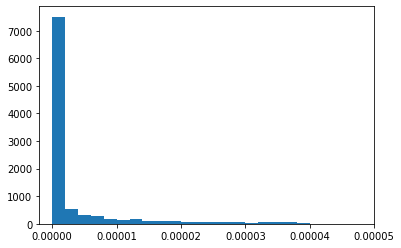

In [10]:
plt.hist(ests, 20);
plt.xticks([0, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5]);

In [11]:
np.max(ests), np.argmax(ests)

(4.002058099702878e-05, 690)

0.3394246408190732

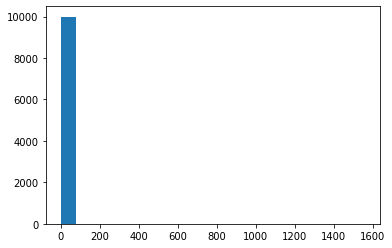

In [12]:
plt.hist(lrs, 20);
lrs.mean()

## Siegmund's Algorithm

We model an insurer's risk reserve process $R_t$ as

$$ R(t) = u + p t - \sum_{i=1}^{N_t} U_i $$

where $u \ge 0$, $p > 0$, $N_t$ is a Poisson process with intensity $\lambda$ and $U_i \overset{\mathrm{i.i.d.}}{\sim} \mathsf{Exponential}(\lambda_U)$. 

For this example, it's easier to work with the net payout

$$ P(t) = \sum_{i=1}^{N_t} U_i - p t \,, $$

The only possible times when the insurer's reserve can become negative is at the times $T_1, T_2, \dots$ when the claims arrive. If we denote the interarrival times as $\xi_i = T_i - T_{i-1} \sim \mathsf{Exponential}(\lambda_\xi)$ (letting $T_0 \equiv 0$), then we have the running sum form

$$ S_n := P(T_n) = \sum_{i=1}^{n} X_i \quad \text{where} \quad X_i = U_i - p \xi_i \,.$$

As $V_i := p \xi_i \sim \mathsf{Exponential}(\lambda_V)$ where $\lambda_V = \lambda_\xi \,/\, p$, then we instead use

$$ S_n = \sum_{i=1}^{n} X_i \quad \text{where} \quad X_i = U_i - V_i \,.$$

The __time of ruin__ given that our initial capital is $u$ is 

$$ \tau_u = \min \{n \ge 1 : S_n > u \} $$

and so our __infinite time ruin probability__ is

$$ \mathbb{P}(\tau_u < \infty) \,. $$

We can roughly estimate this with crude Monte Carlo.

In [13]:
%%time 

rng = rnd.default_rng(1)

u = 1
p = 0.5
λ_U = 6
λ_ξ = 0.005
λ_V = λ_ξ / p
giveUpTime = 200
R = 10**6

alive = np.full(R, True)
S_n = np.zeros(R)

for n in range(1, giveUpTime):
    U_n = rng.exponential(1/λ_U, R)
    V_n = rng.exponential(1/λ_V, R)
    X_n = U_n - V_n
    S_n += X_n
    
    bankruptNow = (S_n > u) & alive
    
    alive[bankruptNow] = False
    
    if np.sum(alive) == 0:
        break
    
ellHat = np.mean(~alive)

print(f"CMC lower bound estimate:\t {ellHat}")

CMC lower bound estimate:	 3e-06
Wall time: 12.4 s


#### Let's exponentially tilt the $X_i$ to make them bigger.

Say $X_i \sim f(\cdot)$ and $M(\theta) = \mathbb{E}_f[ \mathrm{e}^{\theta X} ] $. The proposal distribution is 

$$ g(x) = \frac{ \mathrm{e}^{\theta x} }{ M(\theta) } f(x)
        = \mathrm{e}^{\theta x - \kappa(\theta)} f(x)$$

where $\kappa(\theta) := \log M(\theta).$


The likelihood ratio for a sequence $X_1, X_2, \dots, X_{\tau_u}$ is

$$ \begin{aligned}
L 
&= \prod_{i=1}^{\tau_u} \frac{f(X_i)}{g(X_i)} = \prod_{i=1}^{\tau_u} \frac{f(X_i)}{ \mathrm{e}^{\theta X_i - \kappa(\theta)} f(X_i)}
= \exp\bigl\{ -\theta S_{\tau_u} + \tau_u \kappa(\theta) \bigr\} \,.
\end{aligned} 
$$

Thus, our estimate is

$$ \mathbb{P}(\tau_u < \infty)  
\approx \frac{1}{R} \sum_{r=1}^R 1\{ \tau_u^{(r)} < \infty \} \exp\bigl\{ -\theta S_{\tau_u^{(r)}} + \tau_u^{(r)} \kappa(\theta) \bigr\}  
=: \hat{\ell}_{\mathrm{IS}} \,. $$


#### Does this make bankruptcy more likely? 

Let's calculate the mean of the tilted summands:

$$ \mathbb{E}_g [ X ] 
= \mathbb{E}_f \bigl[ X \frac{g(X)}{f(X)} \bigr]
= \frac{ \mathbb{E}_f \bigl[  X \mathrm{e}^{\theta X} \bigr] }{ M(\theta) } \,.
 $$

Since

$$ M'(\theta) 
=  \frac{\mathrm{d}}{\mathrm{d}\theta} \mathbb{E} \bigl[ \mathrm{e}^{\theta X} \bigr]
=  \mathbb{E}_f \bigl[ \frac{\mathrm{d}}{\mathrm{d}\theta}  \mathrm{e}^{\theta X} \bigr]
= \mathbb{E}_f \bigl[ X \mathrm{e}^{\theta X} \bigr] \,,
$$

and as $\kappa'(\theta) = M'(\theta) / M(\theta)$ we conclude

$$ \mathbb{E}_g [ X ] = \kappa'(\theta) \,. $$

Thus, we should choose $\theta$ such that $\mathbb{E}_g [ X ] \ge 0$ and we will always simulate bankruptcy events $\mathbb{P}_g(\tau_u < \infty) = 1$.

#### What is the moment generating function $M(\theta)$?

Remember $X = U - V$ where

$$U \sim \mathsf{Exponential}(\lambda_U) \text{ and  } V \sim \mathsf{Exponential}(\lambda_V) \,. $$

Also remember $E \sim \mathsf{Exponential}(\lambda)$ has $M_E(\theta) = \lambda / (\lambda - \theta)$ for $\theta < \lambda$. 

Then

$$
\begin{aligned}
M_X(\theta) 
&= \mathbb{E}\bigl[ \mathrm{e}^{\theta (U - V)} \bigr] 
= \mathbb{E}\bigl[ \mathrm{e}^{\theta U} \bigr] \mathbb{E}\bigl[ \mathrm{e}^{-\theta V} \bigr] \\ 
&= M_U(\theta) M_V(-\theta) 
= \frac{\lambda_U}{\lambda_U - \theta} \frac{\lambda_V}{\lambda_V + \theta} \,.
\end{aligned}
$$

#### Which tilting parameter $\theta$  do we choose?

First requirement is that $\theta$ is large enough that $\kappa'(\theta) \ge 0$ so $\mathbb{P}_g(\tau_u < \infty) = 1$. Then

$$
\begin{aligned}
\hat{\ell}_{\mathrm{IS}} 
&= \frac{1}{R} \sum_{r=1}^R 1\{ \tau_u^{(r)} < \infty \} \exp\bigl\{ -\theta S_{\tau_u^{(r)}} + \tau_u^{(r)} \kappa(\theta) \bigr\} \\
&= \frac{1}{R} \sum_{r=1}^R \exp\bigl\{ -\theta S_{\tau_u^{(r)}} \bigr\}
\end{aligned} $$

if $\kappa(\theta) = 0$. This corresponds to solving for $\gamma$

$$M_X(\gamma) = \frac{\lambda_U}{\lambda_U - \gamma} \frac{\lambda_V}{\lambda_V + \gamma}  = 1 $$

Has solution $\gamma = \lambda_U - \lambda_V$ (to check $ M_X(\gamma) = \frac{\lambda_U}{\lambda_V} \frac{\lambda_V}{\lambda_U }  = 1 $).

#### How do we simulate from this distribution?

So we've chosen the proposal distribution for IS to be 

$$
g(x)
= \frac{\mathrm{e}^{\gamma x}}{M_X(\gamma)} f(x) 
= \mathrm{e}^{\gamma x} f(x) \,. 
$$

Under the tilted distribution $g$ where we tilt by $\gamma$, the $X$ has moment generating function

$$ 
\begin{aligned}
\mathbb{E}_g \bigl[ \mathrm{e}^{\theta X } \bigr]
&= \int \mathrm{e}^{\theta x } g(x) \,\mathrm{d}x 
= \int \mathrm{e}^{\theta x } \mathrm{e}^{\gamma x} f(x) \,\mathrm{d}x \\
&= \int \mathrm{e}^{(\theta+\gamma) x}  f(x) \,\mathrm{d}x 
= M_X(\theta + \gamma) \\
&= \frac{\lambda_U}{\lambda_U - (\theta + \gamma)} \frac{\lambda_V}{\lambda_V + (\theta + \gamma)} \\
&= \frac{\lambda_U}{\lambda_U - (\theta + \lambda_U - \lambda_V)} \frac{\lambda_V}{\lambda_V + (\theta + \lambda_U - \lambda_V)} \\
&= \frac{\lambda_V}{\lambda_V - \theta} \frac{\lambda_U}{\lambda_U + \theta} \,.
\end{aligned}
$$

Therefore, we see that the 

$$X_i = U_i - V_i$$ 

variables under the exponential tilted (by $\gamma = \lambda_U - \lambda_V$) distribution have the component distributions

$$U \sim \mathsf{Exponential}(\lambda_V) \text{ and  } V \sim \mathsf{Exponential}(\lambda_U) $$

instead of the original configurations.


In [14]:
%%time 

rng = rnd.default_rng(1)

γ = λ_U - λ_V
giveUpTime = 10**3
R = 10**6

alive = np.full(R, True)
S_n = np.zeros(R)
LRs = np.ones(R)

for n in range(1, giveUpTime+1):
    # Simulate the running sum from
    # the IS proposal distribution 
    U_n = rng.exponential(1/λ_V, R)
    V_n = rng.exponential(1/λ_U, R)
    X_n = U_n - V_n
    S_n += X_n
    
    # Find the ones which go bankrupt after
    # this n-th claim has arrived.
    bankruptNow = (S_n > u) & alive

    # Store the likelihood ratio of this 
    # simulation.
    LRs[bankruptNow] = np.exp(-γ*S_n[bankruptNow])
    
    # Record that this simulation is no 
    # longer running.
    alive[bankruptNow] = 0
    
    # Quit after all R simulations have hit 
    # bankruptcy.
    if np.sum(alive) == 0:
        break

if n == giveUpTime:
    print("We need to keep simulating!")

ests = LRs
ellHat = ests.mean()
sigmaHat = ests.std()
widthCI = 1.96 * sigmaHat / np.sqrt(R)

print(f"CMC estimate:\t {ellHat} (+/- {widthCI})")
print(f"CMC low bound:\t {ellHat-widthCI}")
print(f"CMC upp bound:\t {ellHat+widthCI}")

CMC estimate:	 4.06000097824725e-06 (+/- 1.3874567384834677e-07)
CMC low bound:	 3.921255304398903e-06
CMC upp bound:	 4.1987466520955965e-06
Wall time: 199 ms
